/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


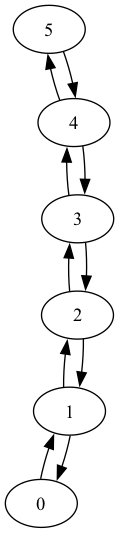

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

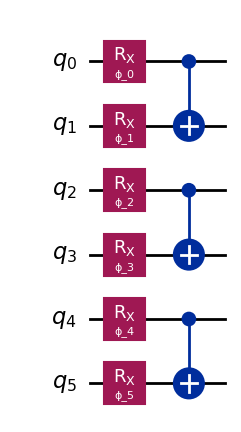

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


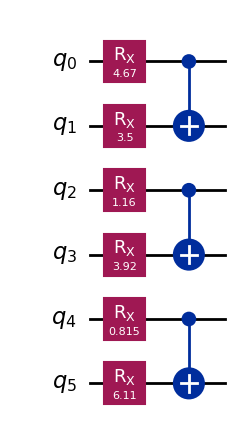

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

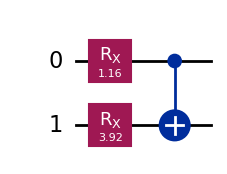

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

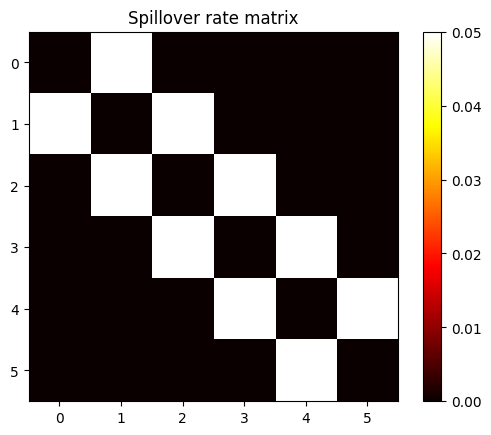

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.05  # γ_2->3
gamma_matrix[3, 2] = 0.05  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
gamma_matrix = 0.0 * np.eye(num_qubits)
for edge in cm.get_edges():
    gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.  , 0.05, 0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.05, 0.  , 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.05, 0.  , 0.05, 0.  ],
       [0.  , 0.  , 0.  , 0.05, 0.  , 0.05],
       [0.  , 0.  , 0.  , 0.  , 0.05, 0.  ]])

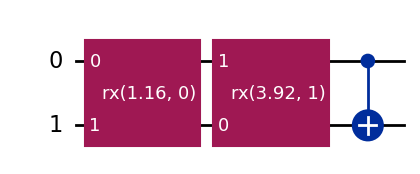

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [9]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [10]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.54833478j, 0.83625892+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.83625892+0.j        , 0.        -0.54833478j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.92432454j, -0.38160732+0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,

In [11]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [12]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '0c6a8049fb29434e8fb5eb7e9f26ddd3',
   'operations': ['h'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': '0c6a8049fb29434e8fb5eb7e9f26ddd3',
   'operations': ['x'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': '0c6a8049fb29434e8fb5eb7e9f26ddd3',
   'operations': ['s'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qub

In [13]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [14]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x15616aa90>,

In [15]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [16]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '0c6a8049fb29434e8fb5eb7e9f26ddd3',
   'operations': ['h'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': '0c6a8049fb29434e8fb5eb7e9f26ddd3',
   'operations': ['x'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}]],
   'probabilities': [0.9925000000000002,
    0.0025000000000000005,
    0.0025000000000000005,
    0.0025000000000000005]},
  {'type': 'qerror',
   'id': '0c6a8049fb29434e8fb5eb7e9f26ddd3',
   'operations': ['s'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'z', 'qub

In [17]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


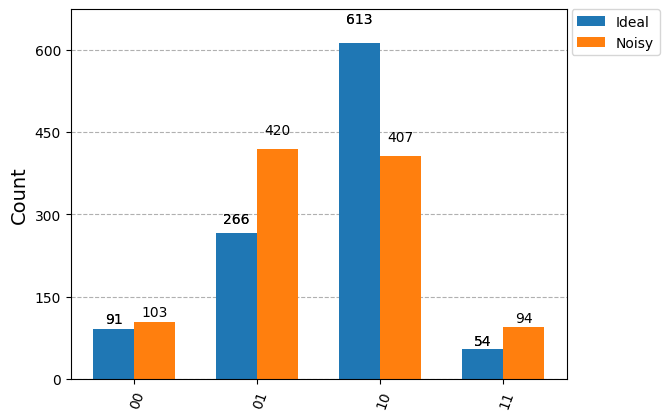

In [18]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [19]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [20]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9566626181361471

In [21]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [31]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-1., high=1., shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[5,],
        n_shots=100,
        sampling_paulis=1000,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)


In [32]:
# Constructing single angle spillover env

from single_angle_spillover_env import OneParamAngleSpilloverEnv

one_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubit=2,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [-1.  -0.5  0.   0.5  1. ]
Observation Vals for Env: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


In [33]:
rescaled_q_env = RescaleAndClipAction(one_env, min_action=-1., max_action=1.)

In [34]:
_, _ = one_env.reset(debug_obs=np.array([np.pi]))

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]


In [36]:
one_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 40, 4),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="channel",
)

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9815836150479491 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.9232190701127457 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.8031431940421763 Std: 0.0
Number of repetitions: 13
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.6433130302604708 Std: 0.0
Number of repetitions: 17
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551


KeyboardInterrupt: 

In [37]:
baseline_reward = []

one_env.clear_history()
for set_obs in one_env.discrete_obs_vals_angles:
    # _obs, info = alt_q_env.reset(debug_obs=np.array([1.]))
    _obs, info = one_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((one_env.batch_size,) + one_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = one_env.step(zero_action)
    baseline_reward.append(np.mean(reward))
    print(f"discrete reward history: {one_env.discrete_reward_history}")


 Number of repetitions: 17
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
(100, 7)
batch action shape: (100, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 0.9860686130013241 Std: 0.00013054975606867274
obs: [-1.]
reward: [4.27268411 4.27694381 4.28584472 4.27345002 4.27527718 4.28089611
 4.27374412 4.27997203 4.28330869 4.2810819  4.28263041 4.26073642
 4.27441233 4.27839288 4.26915121 4.26490319 4.27011041 4.27387252
 4.27537493 4.26289465 4.2871471  4.26565065 4.28743284 4.26600025
 4.27308552 4.27884291 4.2841225  4.24871635 4.26027329 4.27569456
 4.26565478 4.27785422 4.2594834  4.26305929 4.2558416  4.27057596
 4.2713438  4.27652934 4.27933462 4.28802173 4.26779072 4.27177
 4.27263005 4.27707195 4.28146305 4.26164388 4.25188967 4.28848546
 4.26273733 4.29572135 4.26171629 4.27556687 4.26475739 4.27827177
 4.29422356 4.26334934 4.26279137 4.26450815 4.28101535 4.29241767
 4.26075111 4.26454041

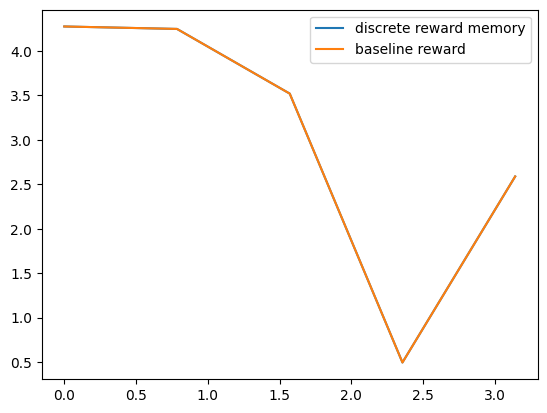

In [38]:
plt.plot(one_env.discrete_obs_vals_angles, one_env.discrete_reward_history[0], label='discrete reward memory')
plt.plot(one_env.discrete_obs_vals_angles, baseline_reward, label='baseline reward')
plt.legend()
plt.show()